In [1]:
from formatting_and_imports import *

### Load elevation data

In [2]:
folder = os.path.join('data', 'final_data')

# Load
eta = np.load(os.path.join(folder, 'elevation.npy')) / 1000 # Units: m. Indices: [scan #, y index, x index]
t_eta = np.load(os.path.join(folder, 'elevation_t.npy')) # Units: (s). Vector of scan times.
x_eta = (np.arange(eta.shape[2])+0.5)/100 # Units: (m). Vector of x positions (center of cell)

# Get scans as close as possible to even in log(t))
target_t = 10**np.linspace(np.log10(t_eta[1]-1), np.log10(t_eta[-1]-1), 40)

ixkeep = []
for i in range(len(target_t)):
    ixkeep.append(np.argmax(t_eta>target_t[i]))

ixkeep = np.unique(ixkeep)
eta = eta[ixkeep]
t_eta = t_eta[ixkeep]

### Plot an example scan

[]

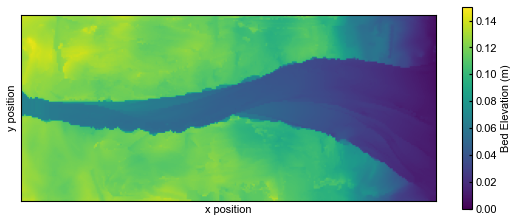

In [3]:
example_index = 5

fig, ax = plt.subplots(figsize=(9, 3.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
im = ax.imshow(eta[example_index], vmin=0, vmax=0.15)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlabel('x position')
ax.set_ylabel('y position')
cbar.set_label('Bed Elevation (m)')
ax.set_xticks([])
ax.set_yticks([])

### Perform Flux Calculations
Sediment load is estimated from repeat scans of topography via sediment mass conservation (the Exner equation):

$$
(1-p)\frac{\partial \eta}{\partial t} = -\left(\frac{\partial q_x}{\partial x} + \frac{\partial q_y}{\partial y}\right). 
$$

Here, $p$ is the bed porosity, $\eta$ is the bed elevation, $q_x$ is the longitidunal component of the sediment flux (in the $x$ direction), $q_y$ is the lateral component of the sediment flux (in the $y$ direction), and $t$ is time. Integrating over the lateral extent of the experimental domain ($y_0$ to $y_1$) and assuming $q_y(y_0)=0$ and $q_y(y_1)=0$ leads to:

$$
(1-p)\int_{y_0}^{y_1}{\frac{\partial \eta}{\partial t} dy} = -\frac{\partial Q_s}{\partial x}
$$

where $Q_s$ is the sediment discharge in the channel, i.e.:

$$
Q_s = \int_{y_0}^{y_1}{q_x dy}
$$

Finally, integrating with respect to x gives an expression for the $Q_s$ as a function of changes in bed elevation:

$$
Q_s = -(1-p)\int_{0}^{x}\int_{y_0}^{y_1}{\frac{\partial \eta}{\partial t}} dy dx + Q_{s0}
$$

where $Q_{s0}$ is the sediment flux at $x=0$, i.e. the sediment supply. Here, $Q_{s0}=0$. 

Presently, we consider a discrete version of this expression to estimate $\overline{Q_s}(x,t_0,t_1)$, the average sediment load past the longitudinal position $x$ from two scans of topography $\eta_0$ and $\eta_1$ collected at times $t_0$ and $t_1$. If each topography scan is represented by an $m \times n$ matrix of elevation values corresponding to evenly spaced measurements in the $x,y$ plane at longitudinal resolution $\Delta x$ and lateral resolution $\Delta y$, the total sediment discharge past the point $x = n_x \Delta x$ may be estimated as: 

$$
\overline{Q_s}(x, t_0, t_1) = -(1-p) \frac{\Delta x \Delta y}{\Delta t}\sum_{i=1}^{n_x} \sum_{j=1}^m \Delta \eta_{ij}.
$$

where $\Delta \eta_{ij} = \eta_{1ij} - \eta_{0ij}$ and $\Delta t = t_1 = t_0$. Noting that the volume of sand upstream of $x$ at time $t$, $V(x, t)$, is given by

$$
V(x, t)=(1-p)\Delta y \Delta x\sum_{i=0}^{n_x} \sum_{j=0}^m \eta_{ij},
$$

the average flux $\overline{Q_s}(x,t_0,t_1)$ may be computed by comparing the volumes of sand in subsequent scans:

$$
\overline{Q_s}(x, t_0, t_1) = \frac{V(x, t_0) - V(x, t_1)}{\Delta t}
$$

This expression is used to calculate sediment discharge below. In subsequent analyses, $\overline{Q_s}(x, t_0, t_1)$ is interpreted as an instantaneous sediment discharge $Q_s(x, t)$ corresponding to the time $t=t_0+\Delta t/2$.


In [4]:
# Calculate total volume of sediment represented by each elevation measurement
dx = 0.01 # resolution = 1 cm
dy = dx
bed_porosity = 0.35

# Calculate volume of sand per longitudinal unit length (inner sum above)
v_xt = np.nansum(eta, axis=1) * (1-bed_porosity) * dy

# Calculate V(x, t) (outer sum above)
V_xt = np.cumsum(v_xt, axis=1) * dx

### Plot volume calculations

Text(0, 0.5, 'V(x, t) (m$^3$)')

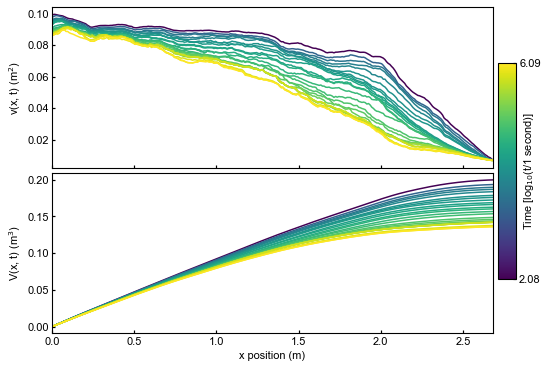

In [5]:
# Plot volume calculations
fig, ax = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
plt.subplots_adjust(right=0.89, hspace=0.03)
cax = plt.axes([0.9, 0.25, 0.03, 0.5])

# make colorbar
cb1 = make_colorbar(cax, 'viridis', [0, 1], 
                    ['{:.2f}'.format(np.log10(t_eta)[0]),'{:.2f}'.format(np.log10(t_eta[-1]))], 
                    'Time [log$_{10}$(t/1 second)]',
                    labelpad=-20)

scaled_logt_eta = np.log10(t_eta) - np.nanmin(np.log10(t_eta))
scaled_logt_eta /= np.nanmax(scaled_logt_eta)

cmap = mpl.cm.viridis
for i in range(v_xt.shape[0]):
    c = cmap(scaled_logt_eta[i])

    ax[0].plot(x_eta, v_xt[i], c=c)
    ax[1].plot(x_eta+(dx/2), V_xt[i], c=c)
    
ax[0].set_xlim(0, 2.68)
ax[0].set_ylabel(r'v(x, t) (m$^2$)')

ax[1].set_xlabel('x position (m)')
ax[1].set_ylabel(r'V(x, t) (m$^3$)')

### Load and plot width data

In [6]:
# Load Width Data
Wdat = np.load(os.path.join(folder, 'width.npy')) # Units: m, indices: [photo #, x index]
t_W = np.load(os.path.join(folder, 'width_t.npy')) # vector of photo times
x_W = (np.arange(Wdat.shape[1])+0.5)/1000 # vector of x position corresponding to width measurements

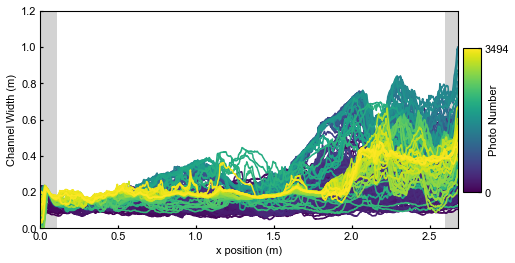

In [7]:
# Plot width data
fig, ax = plt.subplots(figsize=(8,4))
plt.subplots_adjust(right=0.85)
cax = plt.axes([0.86, 0.25, 0.03, 0.5])

# make colorbar
cb1 = make_colorbar(cax, 'viridis', [0, 1], [0, len(t_W)], 'Photo Number', labelpad=-20)

for i in range(0, Wdat.shape[0], 10): # Plot every 100th scan
    c = cmap(t_W[i]/t_W[-1])
    ax.plot(x_W, Wdat[i], c=c)
    
ax.set_xlim(0, 2.68)
ax.set_ylim(0, 1.2)
ax.set_ylabel(r'Channel Width (m)')
ax.set_xlabel('x position (m)')
ax.fill_between([0, 0.1], [0,0], [1.2, 1.2], color='lightgrey', zorder=0)
ax.fill_between([2.6, 2.68], [0,0], [1.2, 1.2], color='lightgrey', zorder=0)

### Spatiotemporal averaging to produce final data

Next, we compute the final estimates of width and sediment discharge for analysis. Note that the measurement resolution differs between the two datatypes, but the final estimates represent an appropriate average over equivalent spatial and temporal domains.

One issue we must overcome is that the sediment discharge is estimated by differencing noisy topogrpahy data. When the changes in bed elevation between scans become small, noise in the topography data produces non-physical negative estimates of the flux. To eliminate this issue, we simply scans that produce negative estimates of flux and average over the appropriate time interval:

Text(0, 0.5, 'Sediment Discharge (m$^3$/s)')

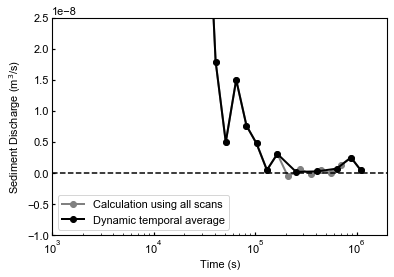

In [8]:
def time_average_flux(time, volume):
    
    # define minimum detectable change in volume
    mindv = 1e-6
    
    # create list of indices correspoinding to usable volume measurements
    indices = [0,]
    for i in range(1, len(volume)):
        if volume[indices[-1]]-volume[i] > mindv:
            indices.append(i)
    
    # Create empty list so that output vector is the same length as input vector
    dv = np.zeros(len(volume))*np.nan
    dt = np.zeros(len(volume))*np.nan
    t = np.zeros(len(volume))*np.nan

    dv[indices[:-1]] = volume[indices[1:]] - volume[indices[:-1]]
    dt[indices[:-1]] = time[indices[1:]] - time[indices[:-1]]
    t[indices[:-1]] = time[indices[:-1]]
    t += dt/2
    
    Qs = -dv/dt
    return Qs[:-1], dt[:-1], t[:-1]

# Naive calculation of sediment discharge without skipping negative fluxes
example_V = V_xt[:,50] # V(x, t) at x = 2 m
dv = np.diff(example_V) # calculate volume differences
dt = np.diff(t_eta) # time between scans
tref = (t_eta[1:]+t_eta[:-1]) / 2 # center of time interval
Qs_ref = -dv/dt # reference flux with negative values

# Appropriate time average that disallows negative values (implemented above)
Qs_dta, dt_dta, t_dta = time_average_flux(t_eta, example_V)
t_plot = t_dta[~np.isnan(t_dta)]
Qs_plot = Qs_dta[~np.isnan(Qs_dta)]

# Plot comparison
fig, ax = plt.subplots()

ax.plot(tref, Qs_ref, c='grey', label='Calculation using all scans', lw=2, marker='o')
ax.plot(t_plot, Qs_plot, c='k', label='Dynamic temporal average', lw=2, marker='o')

ax.legend()

ax.set_xscale('log')
ax.set_xlim(1e3, 2e6)
ax.set_ylim(-1e-8, 0.25e-7)
ax.plot([1e3, 2e6], [0,0], 'k--')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Sediment Discharge (m$^3$/s)')

Flux is calculated using this procedure 10 cm intervals:

In [9]:
x_interval = 10 # multiple of Z measurement resolution -> in this case, 10 = 10 x 1 cm
V_subsample = V_xt[:, x_interval-1::x_interval] # Get volume at 10 cm intervals
x = x_eta[x_interval-1::x_interval]+dx/2 # X coordinate of downstream edge of cells at 10 cm intervals (corresponding to volume measurement)

# Declare arrays for final calculation
Qs = np.ones((V_subsample.shape[0]-1, V_subsample.shape[1])) * np.nan
dt = Qs.copy()
tarr = Qs.copy()

for i in range(V_subsample.shape[1]):
    Qs[:,i], dt[:,i], tarr[:,i] = time_average_flux(t_eta, V_subsample[:,i])
    
xarr, _ = np.meshgrid(x, np.ones(tarr.shape[0]))

Finally, estimates of width are computed by averaging over equivalent spatial and temporal domains

In [10]:
W = np.empty_like(Qs) * np.nan
for i in range(Qs.shape[0]):
    for j in range(Qs.shape[1]):
        if ~np.isnan(Qs[i,j]):
            
            # Get temporal and spatial domain for averaging
            t0, t1 = tarr[i,j] + [-dt[i,j]/2, dt[i,j]/2] 
            x0, x1 = x[j]-x_interval*dx,  x[j] 
            
            # Calculate average width of 10 cm cell between t0 and t1
            Windex_x = (x_W > x0) & (x_W < x1) # boolean index of width measurements between x0 and x1
            Windex_t = (t_W > t0) & (t_W < t1) # boolean index of width measurements between t0 and t1
            merged_index = np.multiply(np.expand_dims(Windex_t, 1), Windex_x) # boolean array (logical AND of above)
            
            # Average width between x0 and x1, t0 and t1
            W[i,j] = np.nanmean(Wdat[merged_index])

### Define other relevant parameters

In [11]:
# Define constants
D = 0.0004          # Grain size (m)
Q = 0.16 * 1e-3     # Water discharge (m^3/s)
Cf = 0.1            # Flow resistance coefficient
tc = 0.035          # Critical stress of sediment motion
mu = 0.7            # Coulomb friction coefficient
R = 1.66            # Submerged specific gravity of sediment
g = 9.81            # Gravitational acceleration (m/s^2)
alpha=1.3           # A constant of proportionality (See equation ??)
Lx = 2.6            # Length of experimental domain (for normalization)

Qwstar = Q/np.sqrt(g * R * D**5)  # Dimensionless water discharge (constant)

# Calculate additional parameters from topography and width data
W_star = W / D                          # Dimensionless width
Qs_star = Qs/np.sqrt(g * R * D**5)      # Dimensionless sediment discharge
qs_star = Qs_star/W_star                # Dimensionless unit sediment discharge

# Compute predictions for Lacey's law and Parker (1+epsilon) model
Qs_star_vec = 10**np.linspace(-4, 3)             # list of dimensionless sediment discharges

#  Lacey's law: W = Wt (Equation ??)
Wstar_Lacey = (np.pi * np.sqrt(Cf * Qwstar/mu)/(alpha * tc**(1/4))) * np.ones(len(Qs_star_vec))
qstar_Lacey = Qs_star_vec/Wstar_Lacey
Wt = Wstar_Lacey[0] * D

# Parker River: tau* = (1+epsilon) tau*_c
qstar_Parker = (3.97 * (0.2 * tc)**(3/2)) * np.ones(len(Qs_star_vec))
Wstar_Parker = Qs_star_vec/qstar_Parker

### Figure 2: Spatiotemporal evolution of the flux

Model:

$$
Q_{s}(x,t) = Q_0 (x/L)^2 e^{(-t_*/\tau)}
$$

In [12]:
t0 = 1.2 * 3600
t1 = 80 * 3600

fit_index = (tarr>t0) & (tarr<t1)
Qs_fit = Qs[fit_index]
x_fit = xarr[fit_index]
t_fit = tarr[fit_index]

1.6958154841880479e-06 41531.396119639125 0.6621943590407738


Text(0, 0.5, 'Predicted $Q_s$ (m$^3$/s)')

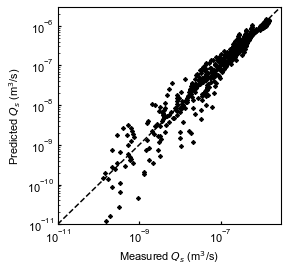

In [13]:
def model(theta, x, t):
    gamma, tau, _ = theta
    return gamma * (x/Lx)**2 * np.exp(-t/tau)

def log_likelihood(theta, x, t, Qs):
    gamma, tau, sigma = theta
    
    if (theta<0).any():
        return -np.inf
    else:
        prediction = model(theta, x, t)
        p = norm.pdf(np.log(Qs), np.log(prediction), sigma)
        return np.sum(np.log(p))

from scipy.optimize import minimize

initial_guess = np.array([1e-6, 10000, 4])

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = initial_guess + [1e-9, 1e3, 0.1] * np.random.randn(3)
soln = minimize(nll, initial, args=(x_fit, t_fit, Qs_fit))
Q0, tau, sigma  = soln.x
print(Q0, tau, sigma)
Qs_predicted = model(soln.x, x_fit, t_fit)

fig, ax = plt.subplots(figsize=(4,4))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(Qs_fit, Qs_predicted, c='k', marker='D', lw=0, markersize=3)
ax.plot([1e-11, 3e-6], [1e-11, 3e-6], 'k--')
ax.set_xlim(1e-11, 3e-6)
ax.set_ylim(1e-11, 3e-6)
ax.set_xlabel(r'Measured $Q_s$ (m$^3$/s)')
ax.set_ylabel(r'Predicted $Q_s$ (m$^3$/s)')

In [14]:
Qsnorm_xplot = Qs/(Q0 * np.exp(-tarr/tau))
xarr_exp = xarr[fit_index]
Qsnorm_xplot_exp = Qsnorm_xplot[fit_index]

Qsnorm_tplot = Qs/(Q0 * (xarr/Lx)**2)

def sample_stats(sample):
    if len(sample)<5:
        return np.nan, [np.nan, np.nan]
    else:
        logmean = np.nanmean(np.log(Qsample))
        elogmean = np.exp(logmean)#np.nanmedian(Qsample)
        logstd = np.nanstd(np.log(Qsample))
        nsamps = np.sum(~np.isnan(Qsample))
        logCI = 2*logstd/np.sqrt(nsamps)
        low_err = elogmean - elogmean/np.exp(logCI)
        up_err = elogmean*np.exp(logCI) - elogmean
        return elogmean, [low_err, up_err]

xbins = np.linspace(0.05, 2.65, 27)
xplot = (xbins[1:] + xbins[:-1])/2

mean_xplot = np.empty(len(xplot))
err_xplot = np.empty((2, len(xplot)))
for i in range(len(xplot)):
    Qsample = Qsnorm_xplot_exp[(xarr_exp>xbins[i]) & (xarr_exp<xbins[i+1])]
    mean_xplot[i], err_xplot[:,i] = sample_stats(Qsample)

mint = np.nanmin(tarr)
maxt = np.nanmax(tarr)
nbins = 30
tbins = 10**np.linspace(np.log10(mint-1), np.log10(maxt+1), nbins+1)

mean_tplot = np.empty(nbins)
err_tplot = np.empty([2, nbins])
tplot = np.empty(nbins)
for i in range(nbins):
    sample_index = (tarr>tbins[i]) & (tarr<tbins[i+1])
    
    Qsample = Qsnorm_tplot[sample_index]
    mean_tplot[i], err_tplot[:,i] = sample_stats(Qsample)
    
    tplot[i] = 10**np.nanmean(np.log10(tarr[sample_index]))

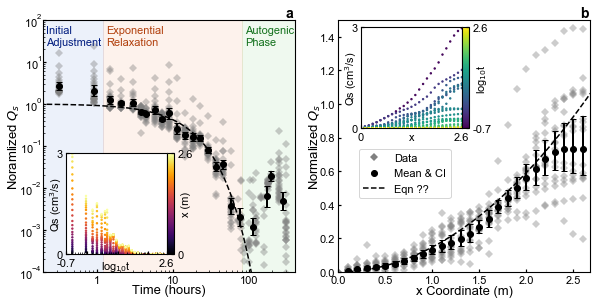

In [23]:
# Create axes
ax, axins, cax = fig2_axes()

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(0.2, 400)
ax[0].set_ylim(1e-4, 100)

ax[0].plot(tarr/3600, Qsnorm_tplot, c='grey', lw=0, mew=0, marker='D', alpha=0.4)
ax[0].plot(tplot/3600, mean_tplot, c='k', marker='o', lw=0)
ax[0].errorbar(tplot/3600, mean_tplot, err_tplot, c='k', ls='none', lw=2, capsize=3, zorder=10)

te = 10**np.linspace(2, 6, 5000)
ax[0].plot(te/3600, np.exp(-te/tau), 'k--')

ax[0].fill_between([0.2, t0/3600], [1e-4, 1e-4], [100, 100], color=sns.color_palette('muted')[0], alpha=0.1)
ax[0].text(0.2*1.1, 25, 'Initial\nAdjustment', color=sns.color_palette('dark')[0])

ax[0].fill_between([t0/3600, t1/3600], [1e-4, 1e-4], [100, 100], color=sns.color_palette('muted')[1], alpha=0.1)
ax[0].text(1.1*t0/3600, 25, 'Exponential\nRelaxation', color=sns.color_palette('dark')[1])

ax[0].fill_between([t1/3600, 400], [1e-4, 1e-4], [100, 100], color=sns.color_palette('muted')[2], alpha=0.1)
ax[0].text(1.1*t1/3600, 25, 'Autogenic\nPhase', color=sns.color_palette('dark')[2])

ax[0].set_xlabel('Time (hours)', fontsize=13, labelpad=-1)
ax[0].set_ylabel(r'Noramlized $Q_s$', fontsize=13, labelpad=-3)
ax[0].set_xticks([1, 10, 100])
ax[0].set_xticklabels([1,10,100])
ax[0].tick_params(axis='y', which='major', pad=1)

ax[1].set_xlim(0, 2.68)
ax[1].set_ylim(0, 1.5)
ax[1].plot(0, 0, c='grey', lw=0, mew=0, marker='D', alpha=1, label='Data')
ax[1].plot(xarr_exp, Qsnorm_xplot_exp, c='grey', lw=0, mew=0, marker='D', alpha=0.4)
ax[1].plot(xplot, mean_xplot, c='k', marker='o', lw=0, label='Mean & CI')
ax[1].errorbar(xplot, mean_xplot, err_xplot, c='k', ls='none', lw=2, capsize=3, zorder=10)

xp = 10**np.linspace(-1,1, 5000)
ax[1].plot(xp, (xp/Lx)**2, 'k--', label='Eqn ??')
ax[1].legend(loc='lower left', bbox_to_anchor=(0.06, 0.27))

ax[1].set_xlabel('x Coordinate (m)', fontsize=13, labelpad=-1)
ax[1].set_ylabel(r'Normalized $Q_s$',  fontsize=13, labelpad=-3)

axins[0].scatter(tarr/3600, Qs, c=xarr, cmap='inferno', vmin=0, vmax=2.6, s=2)
axins[0].set_xscale('log')
axins[0].set_ylim(0, 0.000003)
axins[0].set_yticks([0, 3e-6])
axins[0].set_yticklabels([0, 3])
axins[0].set_ylabel(r'Qs (cm$^3$/s)', labelpad=-8)
axins[0].set_xlim(0.2,400)
axins[0].set_xticks([0.2,1, 10, 100, 400])
axins[0].set_xticklabels([-0.7, '','','',2.6])
axins[0].set_xlabel(r'log$_{10}$t', labelpad=-10)

make_colorbar(cax[0], 'inferno', [0, 1], 
                    [0,2.6], 'x (m)',
                    labelpad=-12)

axins[1].scatter(xarr, Qs, c=np.log10(tarr), cmap='viridis', vmin=3, vmax=6,  s=2)
axins[1].set_ylim(0, 0.000003)
axins[1].set_yticks([0, 3e-6])
axins[1].set_yticklabels([0, 3])
axins[1].set_ylabel(r'Qs (cm$^3$/s)', labelpad=-8)
axins[1].set_xlim(0, 2.6)
axins[1].set_xticks([0,2.6])
axins[1].set_xticklabels([0, 2.6])
axins[1].set_xlabel(r'x', labelpad=-10)

make_colorbar(cax[1], 'viridis', [0, 1], 
                    ['{:.1f}'.format(np.log10(0.2)),'{:.1f}'.format(np.log10(400))], 
                    r'log$_{10}$t',
                    labelpad=-18)

ax[0].text(0.96, 1.01, 'a', fontsize=14, transform=ax[0].transAxes, weight='bold')
ax[1].text(0.96, 1.01, 'b', fontsize=14, transform=ax[1].transAxes, weight='bold')

plt.savefig('figures\\fig2_raw.svg')

### Figure 3: Unstable channels obey Lacey's Law $(W=W_t)$

Load laminar channel data (Digitized from Figure 5, Abramian et al., 2019).

In [16]:
laminar_channels = pd.read_csv(os.path.join('data', 'final_data','abramian_2019.csv'))

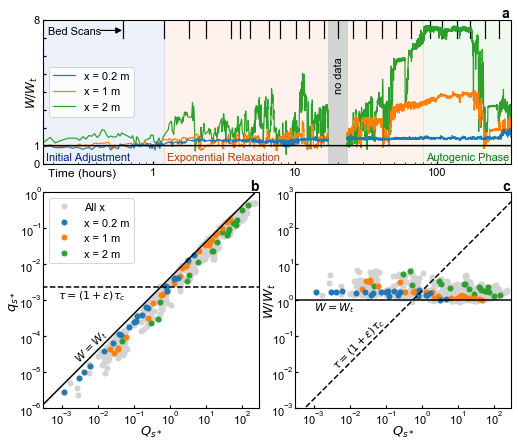

In [17]:
ax = fig3_axes()

########################################################
# Width over time
########################################################
# Time in hours
tW_h = t_W/3600

# Get index of camera error (plot separately to prevent connecting line)
ix_camera_error = np.nanmax(np.argwhere(np.diff(t_W) == np.nanmax(np.diff(t_W))))+1

# Plot before camera error
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error, 100]/Wt, c=sns.color_palette()[0], zorder=3, label='x = 0.2 m', lw=1.2)
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error,1000]/Wt, c=sns.color_palette()[1], zorder=2, label='x = 1 m', lw=1.2)
ax[0].plot(tW_h[:ix_camera_error], Wdat[:ix_camera_error,2000]/Wt, c=sns.color_palette()[2], zorder=1, label='x = 2 m', lw=1.2)

# Plot after camera error
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:, 100]/Wt, c=sns.color_palette()[0], zorder=3, lw=1.2)
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:,1000]/Wt, c=sns.color_palette()[1], zorder=2, lw=1.2)
ax[0].plot(tW_h[ix_camera_error:], Wdat[ix_camera_error:,2000]/Wt, c=sns.color_palette()[2], zorder=1, lw=1.2)

ax[0].fill_between([tW_h[0], t0/3600], [0, 0], [10, 10], color=sns.color_palette('muted')[0], alpha=0.1, zorder=0)
ax[0].fill_between([t0/3600, t1/3600], [0, 0], [10, 10], color=sns.color_palette('muted')[1], alpha=0.1, zorder=0)
ax[0].fill_between([t1/3600, 400], [0, 0], [10, 10], color=sns.color_palette('muted')[2], alpha=0.1, zorder=0)
ax[0].text(tW_h[0]*1.05, 0.2, 'Initial Adjustment', color=sns.color_palette('dark')[0])
ax[0].text(1.05*t0/3600, 0.2, 'Exponential Relaxation', color=sns.color_palette('dark')[1])
ax[0].text(1.05*t1/3600, 0.2, 'Autogenic Phase', color=sns.color_palette('dark')[2])

# Plot W/Wt = 1
ax[0].plot(tW_h, t_W**0, 'k', zorder=4)

# X axis formatting
ax[0].set_xscale('log')
ax[0].set_xlim(tW_h[0], tW_h[-1])
ax[0].text(0.01,-0.09,'Time (hours)', fontsize=12, transform=ax[0].transAxes)
ax[0].set_xticks([1, 10, 100])
ax[0].set_xticklabels([1, 10, 100])

# Y axis formatting
ax[0].set_ylim(0, 8)
ax[0].set_ylabel(r'$W/W_t$', fontsize=12, labelpad=-7)
ax[0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax[0].set_yticklabels([0,1,'','','','','','',8])

# Mark camera error and annotate
ax[0].fill_between(tW_h[ix_camera_error-1:ix_camera_error+1], [0, 0], [10,10], zorder=0, color='lightgrey')
ax[0].text(tW_h[ix_camera_error-1]+1.7, 4, 'no data', rotation=90, zorder=4)

# Plot scan times and annotate
ax[0].text(0.01, 0.9, 'Bed Scans', transform=ax[0].transAxes)
ax[0].arrow(0.43, 7.4, 0.12, 0, head_length=0.05, head_width=0.3, color='k')
for i in range(len(t_eta)):
    ti = t_eta[i]/3600
    ax[0].plot([ti, ti], [7, 10], 'k', lw=1.2, zorder=0)

# Other annotations
ax[0].legend(loc='center left')
ax[0].text(0.98, 1.015, 'a', fontsize=14, transform=ax[0].transAxes, weight='bold')

################################################################
# Unit sediment flux vs total sediment load
################################################################
# Plot all data
ax[1].plot(Qs_star.ravel(), qs_star.ravel(), c='lightgrey', marker='o', markersize=5, lw=0, label='All x', zorder=0)

# Plot data from example cross-sections
ax[1].plot(Qs_star[:,0], qs_star[:,0], c=sns.color_palette()[0], marker='o', markersize=5, lw=0, label='x = 0.2 m', zorder=3)
ax[1].plot(Qs_star[:,9], qs_star[:,9], c=sns.color_palette()[1], marker='o', markersize=5, lw=0, label='x = 1 m', zorder=2)
ax[1].plot(Qs_star[:,19], qs_star[:,19], c=sns.color_palette()[2], marker='o', markersize=5, lw=0, label='x = 2 m', zorder=1)

# X axis formatting
ax[1].set_xlabel(r'$Q_{s*}$', fontsize=13, labelpad=-3)
ax[1].set_xscale('log')
ax[1].set_xlim(3e-4, 3e2)
ax[1].set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
ax[1].tick_params(axis='both', which='major', pad=1)

# Y axis formatting
ax[1].set_ylabel(r'$q_{s*}$', fontsize=13, labelpad=-2)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-6, 1e0)
ax[1].minorticks_off()

# Plot reference lines and annotate
ax[1].plot(Qs_star_vec, qstar_Lacey, 'k', zorder=4)
ax[1].plot(Qs_star_vec, qstar_Parker, 'k--', zorder=4)
ax[1].text(0.8e-3, 1.1e-3, r'$\tau = (1+\varepsilon)\tau_c$')
ax[1].text(2e-3, 2e-5, r'$W=W_t$', rotation=45)

# Other annotations
ax[1].legend()
ax[1].text(0.96, 1.01, 'b', fontsize=14, transform=ax[1].transAxes, weight='bold')

################################################################
# Relative width vs total sediment load
################################################################
# Plot all data
ax[2].plot(Qs_star.ravel(), W.ravel()/Wt, c='lightgrey', marker='o', markersize=5, lw=0, zorder=0)

# Plot data from example cross-sections
ax[2].plot(Qs_star[:,0], W[:,0]/Wt, c=sns.color_palette()[0], marker='o', markersize=5, lw=0, zorder=3)
ax[2].plot(Qs_star[:,9], W[:,9]/Wt, c=sns.color_palette()[1], marker='o', markersize=5, lw=0, zorder=2)
ax[2].plot(Qs_star[:,19], W[:,19]/Wt, c=sns.color_palette()[2], marker='o', markersize=5, lw=0, zorder=1)

# X axis formatting
ax[2].set_xlabel(r'$Q_{s*}$', fontsize=13, labelpad=-3)
ax[2].set_xscale('log')
ax[2].set_xlim(3e-4, 3e2)
ax[2].set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
ax[2].tick_params(axis='both', which='major', pad=1)

# Y axis formatting
ax[2].set_ylabel(r'$W/W_t$', fontsize=13, labelpad=-7)
ax[2].set_yscale('log')
ax[2].set_ylim(1e-3, 1e3)
ax[2].minorticks_off()

# Plot reference lines and annotate
ax[2].plot(Qs_star_vec, Qs_star_vec**0, 'k', zorder=4)
ax[2].plot(Qs_star_vec, Wstar_Parker/Wstar_Lacey, 'k--', zorder=4)
ax[2].text(1e-3, 5.1e-1, r'$W=W_t$')
ax[2].text(2.8e-3, 1.27e-2, r'$\tau = (1+\varepsilon)\tau_c$', rotation=45)

# Other annotations
ax[2].text(0.96, 1.01, 'c', fontsize=14, transform=ax[2].transAxes, weight='bold')

plt.savefig('figures\\fig3_raw.svg')